In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.iolib.summary2 import summary_col
import numpy as np
import seaborn as sns
from scipy.stats import ttest_rel, wilcoxon

In [2]:
df = pd.read_csv('../survey_experiment/results-survey929121.csv')

In [3]:
display(df.head())

,id,submitdate,lastpage,startlanguage,seed,startdate,datestamp,block,M01,M02,...,K02Time,K03Time,groupTime27791,G00Q02Time,G00Q03Time,G00Q04Time,groupTime29372,sexTime,ageTime,educTime
0,1,2025-07-05 14:43:13,6,de,352066507,2025-07-05 14:40:44,2025-07-05 14:43:13,1,NaN,NaN,...,NaN,NaN,10.76,NaN,NaN,NaN,10.16,NaN,NaN,NaN
1,2,2025-07-05 16:04:16,6,de,1428878115,2025-07-05 16:00:57,2025-07-05 16:04:16,1,NaN,NaN,...,NaN,NaN,18.21,NaN,NaN,NaN,19.19,NaN,NaN,NaN
2,3,NaN,2,de,1661822640,2025-07-05 19:01:52,2025-07-05 19:01:59,1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2025-07-05 19:07:06,6,de,1661822640,2025-07-05 19:01:55,2025-07-05 19:07:06,1,NaN,NaN,...,NaN,NaN,51.40,NaN,NaN,NaN,16.15,NaN,NaN,NaN
4,5,2025-07-05 19:43:57,6,de,619222703,2025-07-05 19:41:42,2025-07-05 19:43:57,0,Wilde Müllkippe 🧹,Straßen 🚧,...,NaN,NaN,13.93,NaN,NaN,NaN,11.77,NaN,NaN,NaN


In [4]:
print(list(df.columns))

['id', 'submitdate', 'lastpage', 'startlanguage', 'seed', 'startdate', 'datestamp', 'block', 'M01', 'M02', 'M03', 'M04', 'M05', 'M06', 'M07', 'M08', 'P01', 'P01V', 'P01M', 'P01N', 'P01S', 'P02', 'P02V', 'P02M', 'P02N', 'P02S', 'P03', 'P03V', 'P03M', 'P03N', 'P03S', 'P04', 'P04V', 'P04M', 'P04N', 'P04S', 'P05', 'P05V', 'P05M', 'P05N', 'P05S', 'P06', 'P06V', 'P06M', 'P06N', 'P06S', 'P07', 'P07V', 'P07M', 'P07N', 'P07S', 'P08', 'P08V', 'P08M', 'P08N', 'P08S', 'K01', 'K02', 'K03', 'G00Q02[SQ001]', 'G00Q02[SQ002]', 'G00Q02[SQ003]', 'G00Q03[SQ001]', 'G00Q03[SQ002]', 'G00Q03[SQ003]', 'G00Q04[SQ001]', 'G00Q04[SQ002]', 'G00Q04[SQ003]', 'sex', 'age', 'educ', 'interviewtime', 'groupTime27792', 'blockTime', 'groupTime27793', 'M01Time', 'M02Time', 'M03Time', 'M04Time', 'M05Time', 'M06Time', 'M07Time', 'M08Time', 'groupTime27847', 'P01Time', 'P01VTime', 'P01MTime', 'P01NTime', 'P01STime', 'P02Time', 'P02VTime', 'P02MTime', 'P02NTime', 'P02STime', 'P03Time', 'P03VTime', 'P03MTime', 'P03NTime', 'P03ST

In [6]:
# respondents per block
df[df['K01'].isna()==False]['block'].value_counts()

block
0    37
1    36
Name: count, dtype: int64

# Subjective ease of categorization

For this, K01 measures categorization confidence (the outcome of interest). We also have K02, which assesses whether there were difficulties, and K03 as an open text option.

## Categorization confidence

### Descriptive statistics

In [7]:
cat_confidence = ['Sehr sicher', 'Sicher', 'Weder sicher noch unsicher', 'Unsicher', 'Sehr unsicher']
df['K01'] = pd.Categorical(df['K01'], categories=cat_confidence, ordered=True)
print(df['K01'].value_counts().sort_index())
print(df.groupby('block')['K01'].value_counts(normalize=True).sort_index())

K01
Sehr sicher                    6
Sicher                        43
Weder sicher noch unsicher    14
Unsicher                       8
Sehr unsicher                  2
Name: count, dtype: int64
block  K01                       
0      Sehr sicher                   0.108108
       Sicher                        0.513514
       Weder sicher noch unsicher    0.216216
       Unsicher                      0.135135
       Sehr unsicher                 0.027027
1      Sehr sicher                   0.055556
       Sicher                        0.666667
       Weder sicher noch unsicher    0.166667
       Unsicher                      0.083333
       Sehr unsicher                 0.027778
Name: proportion, dtype: float64


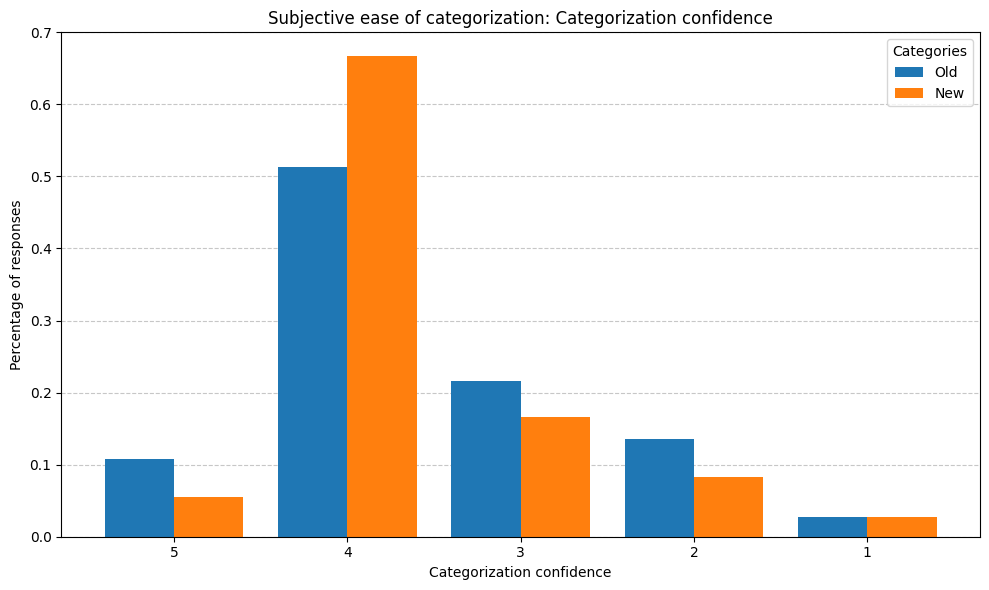

In [8]:
perc = df.groupby('block')['K01'].value_counts(normalize=True).sort_index().unstack(level=0).fillna(0)

ax = perc.plot(kind='bar', figsize=(10,6), width=0.8)
plt.title('Subjective ease of categorization: Categorization confidence')
plt.ylabel('Percentage of responses')
plt.xlabel('Categorization confidence')
ax.set_xticklabels([5,4,3,2,1], rotation=0)
ax.grid(True, axis='y', linestyle='--', alpha=0.7)
ax.set_axisbelow(True)
ax.legend(title='Categories', labels=['Old', 'New'])
plt.tight_layout()
plt.show()

## Regression

We will begin with a simple OLS, just using block as predictor and then continuously add other predictors.

In [9]:
mapping = {
    'Sehr sicher': 5,
    'Sicher': 4,
    'Weder sicher noch unsicher': 3,
    'Unsicher': 2,
    'Sehr unsicher': 1
}
df['K01_num'] = df['K01'].map(mapping)
df_model = df.dropna(subset=['K01_num', 'block'])
df_model['K01_num'] = pd.to_numeric(df_model['K01_num'])
model = smf.ols('K01_num ~ block', data=df_model).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                K01_num   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.011
Method:                 Least Squares   F-statistic:                    0.2179
Date:                Thu, 10 Jul 2025   Prob (F-statistic):              0.642
Time:                        14:30:23   Log-Likelihood:                -94.868
No. Observations:                  73   AIC:                             193.7
Df Residuals:                      71   BIC:                             198.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.5405      0.148     23.932      0.0

/tmp/ipykernel_18137/3752901577.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model['K01_num'] = pd.to_numeric(df_model['K01_num'])


/tmp/ipykernel_18137/1046004398.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model['fitted'] = pred_table['mean']
/tmp/ipykernel_18137/1046004398.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model['mean_ci_lower'] = pred_table['mean_ci_lower']
/tmp/ipykernel_18137/1046004398.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.o

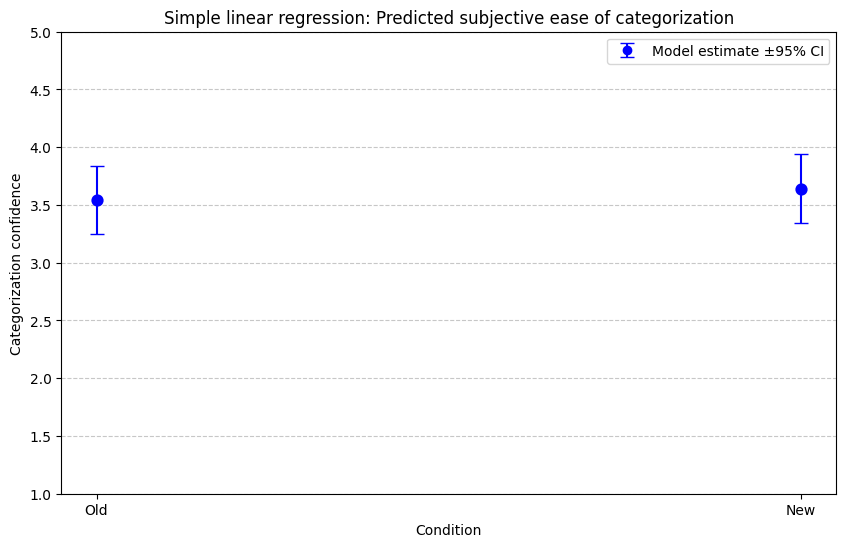

In [23]:
pred_table = model.get_prediction().summary_frame(alpha=0.05)
df_model['fitted'] = pred_table['mean']
df_model['mean_ci_lower'] = pred_table['mean_ci_lower']
df_model['mean_ci_upper'] = pred_table['mean_ci_upper']

# Plot point estimates with CI
plt.figure(figsize=(10,6))
sns.pointplot(x='block', y='K01_num', data=df_model, 
              ci=None, color='blue', join=False)

# Overlay predicted means from model
mean_preds = df_model.groupby('block')[['fitted', 'mean_ci_lower', 'mean_ci_upper']].mean().reset_index()

plt.errorbar(mean_preds['block'], mean_preds['fitted'],
             yerr=[mean_preds['fitted'] - mean_preds['mean_ci_lower'],
                   mean_preds['mean_ci_upper'] - mean_preds['fitted']],
             fmt='o', color='blue', capsize=5, label='Model estimate ±95% CI')

plt.ylabel('Categorization confidence')
plt.ylim(1,5)
plt.xlabel('Condition')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.xticks([0, 1], ['Old', 'New'])
plt.title('Simple linear regression: Predicted subjective ease of categorization')
plt.legend()
plt.show()

Predictors:
- Bekanntheit Mangelmelder
- Sozio-demographisch

In [24]:

df['MM_bekannt'] = df['G00Q02[SQ002]'].apply(lambda x: 1 if x == 'Nein' else 0)
df['MM_OL_bekannt'] = df['G00Q03[SQ001]'].apply(lambda x: 1 if x == 'Ja' else 0)
df['MM_OL_benutzt'] = df['G00Q04[SQ001]'].apply(lambda x: 1 if x == 'Ja' else 0)


In [25]:
df['educ'].value_counts()
# transform into with/without university degree
df['educ_bin'] = df['educ'].apply(lambda x: 1 if x == 'Hochschulabschluss' else 0)

In [26]:
df['sex'].value_counts()
# done because of small sample size, which makes Divers a bad reference category (no discrimination intended)
def binarize_sex(x):
    if x == 'Männlich':
        return 1
    elif x == 'Weiblich':
        return 0
    elif x == 'Divers':
        return np.nan
df['sex_bin'] = df['sex'].apply(binarize_sex)

In [27]:
df['age'].value_counts()

age
21.0    12
26.0     8
25.0     8
20.0     6
29.0     5
23.0     5
27.0     5
22.0     5
19.0     4
24.0     4
33.0     3
28.0     3
30.0     2
31.0     1
Name: count, dtype: int64

In [36]:
df_model = df.dropna(subset=['K01_num', 'block', 'MM_bekannt', 'educ_bin', 'sex_bin', 'age'])
df_model['K01_num'] = pd.to_numeric(df_model['K01_num'])
formula = "K01_num ~ block + MM_bekannt + educ_bin + sex_bin + age"
model = smf.ols(formula, data=df_model).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                K01_num   R-squared:                       0.075
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.016
Date:                Thu, 10 Jul 2025   Prob (F-statistic):              0.416
Time:                        15:02:10   Log-Likelihood:                -83.022
No. Observations:                  69   AIC:                             178.0
Df Residuals:                      63   BIC:                             191.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.1279      0.894      4.615      0.0

/tmp/ipykernel_18137/2458507958.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model['K01_num'] = pd.to_numeric(df_model['K01_num'])


In [37]:
with open('model_summary.html', 'w') as f:
    f.write(model.summary().as_html())

In [38]:
with open('model_summary.txt', 'w') as f:
    f.write(model.summary().as_text())

In [34]:
# Get summary table
summary = summary_col([model], stars=True, model_names=['Model'])

# Change row labels
new_names = {
    "C(sex, Treatment(reference='Weiblich'))[T.Männlich]": "Sex (Male vs Female)",
    "C(sex, Treatment(reference='Weiblich'))[T.Divers]": "Gender (Diverse vs Female)",
    "block": "Condition (New vs Old)",
    "MM_bekannt": "Familiarity",
    "educ_bin": "Education",
    "age": "Age"
}

# Replace index
summary.tables[0].index = [new_names.get(idx, idx) for idx in summary.tables[0].index]

# Print or save
print(summary)


                             Model  
------------------------------------
Intercept                  3.9927***
                           (0.9042) 
Gender (Diverse vs Female) -1.4913**
                           (0.6392) 
Sex (Male vs Female)       -0.2828  
                           (0.2294) 
Condition (New vs Old)     0.0393   
                           (0.2080) 
Familiarity                -0.2928  
                           (0.2708) 
Education                  0.3554   
                           (0.2656) 
Age                        -0.0102  
                           (0.0381) 
R-squared                  0.1544   
R-squared Adj.             0.0751   
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01


Check whether linear model is sufficient (or whether we need to switch to e.g., ordered logit). Expectation: residulas will not be normally distributed.

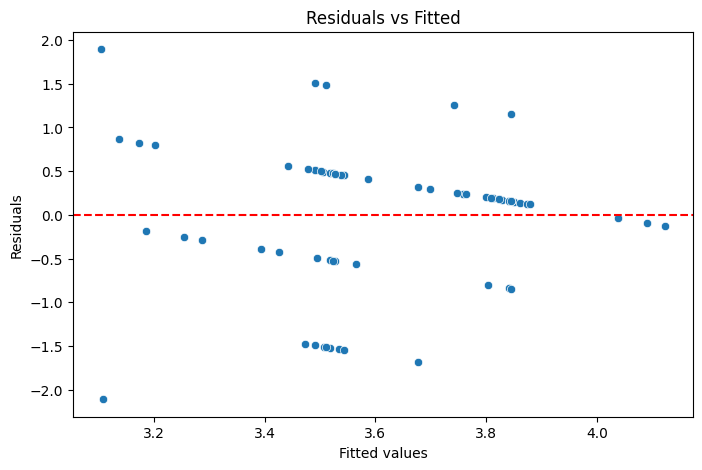

In [39]:
fitted_vals = model.fittedvalues
residuals = model.resid
plt.figure(figsize=(8,5))
sns.scatterplot(x=fitted_vals, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted')
plt.show()

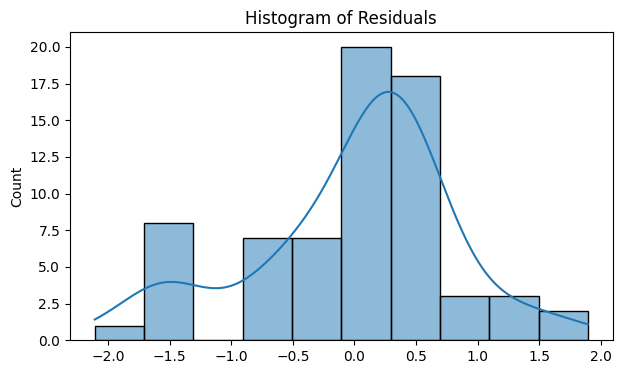

In [40]:
plt.figure(figsize=(7,4))
sns.histplot(residuals, kde=True)
plt.title('Histogram of Residuals')
plt.show()

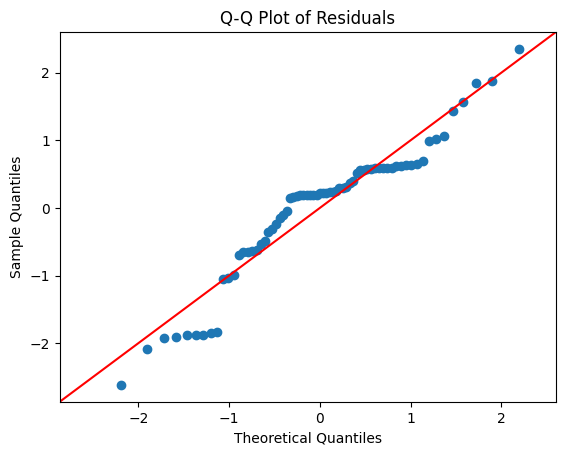

In [41]:
sm.qqplot(residuals, line='45', fit=True)
plt.title('Q-Q Plot of Residuals')
plt.show()

Residuals are not exactly normally distributed, but better than expected.

In [42]:
bp_test = het_breuschpagan(residuals, model.model.exog)
labels = ['Lagrange multiplier stat', 'p-value', 'f-value', 'f p-value']
print(dict(zip(labels, bp_test)))

{'Lagrange multiplier stat': np.float64(15.821351434026237), 'p-value': np.float64(0.007373071384996104), 'f-value': np.float64(3.7486666819187193), 'f p-value': np.float64(0.004922005491581218)}


Errors are homoskedastic -> good.

In [43]:
X = model.model.exog
vif_data = pd.DataFrame()
vif_data["feature"] = model.model.exog_names
vif_data["VIF"] = [variance_inflation_factor(X, i) for i in range(X.shape[1])]
print(vif_data)

      feature        VIF
0   Intercept  77.578698
1       block   1.017777
2  MM_bekannt   1.055833
3    educ_bin   1.663291
4     sex_bin   1.145669
5         age   1.811270


No multicollinearity -> good.

No need to check for extreme values or outliers. There will be none, given the bounded scales we are using (at least no univariate outliers).

# Objective ease of categorization

In [44]:
pd.set_option('display.max_rows', None)
display(df.head(1))

,id,submitdate,lastpage,startlanguage,seed,startdate,datestamp,block,M01,M02,...,groupTime29372,sexTime,ageTime,educTime,K01_num,MM_bekannt,MM_OL_bekannt,MM_OL_benutzt,educ_bin,sex_bin
0,1,2025-07-05 14:43:13,6,de,352066507,2025-07-05 14:40:44,2025-07-05 14:43:13,1,NaN,NaN,...,10.16,NaN,NaN,NaN,4,1,1,0,1,1.0


# Go through each picture and see categories chosen

In [51]:
for i in range(1,8):
    print(f'Old categories: {df[f'M0{i}'].value_counts(normalize=True)}')
    print(f'New categories: {df[f'P0{i}'].value_counts(normalize=True)}')

Old categories: M01
Wilde Müllkippe 🧹    0.717949
Abfall 🗑             0.282051
Name: proportion, dtype: float64
New categories: P01
Müllentsorgung                0.742857
Natur & öffentliche Plätze    0.257143
Name: proportion, dtype: float64
Old categories: M02
Straßen 🚧    1.0
Name: proportion, dtype: float64
New categories: P02
Verkehr & Infrastruktur    1.0
Name: proportion, dtype: float64
Old categories: M03
Abfall 🗑             0.564103
Wilde Müllkippe 🧹    0.410256
Straßen 🚧            0.025641
Name: proportion, dtype: float64
New categories: P03
Müllentsorgung                0.885714
Natur & öffentliche Plätze    0.085714
Sonstiges                     0.028571
Name: proportion, dtype: float64
Old categories: M04
Wilde Müllkippe 🧹    0.641026
Abfall 🗑             0.358974
Name: proportion, dtype: float64
New categories: P04
Müllentsorgung                0.971429
Natur & öffentliche Plätze    0.028571
Name: proportion, dtype: float64
Old categories: M05
Abfall 🗑             0.74

In [46]:
# look at sub-categories
sub_cats = ['V', 'M', 'N', 'S']
for i in range(1,8):
    print(f'New categories: {df[f'P0{i}'].value_counts()}')
    for j in sub_cats:
        print(df[f'P0{i}{j}'].value_counts())

New categories: P01
Müllentsorgung                26
Natur & öffentliche Plätze     9
Name: count, dtype: int64
Series([], Name: count, dtype: int64)
P01M
Umweltverschmutzung      22
Öffentliche Mülleimer     4
Name: count, dtype: int64
P01N
Umweltverschmutzung    8
Sonstiges              1
Name: count, dtype: int64
Series([], Name: count, dtype: int64)
New categories: P02
Verkehr & Infrastruktur    35
Name: count, dtype: int64
P02V
Asphalt & Schlaglöcher    31
Fahrradwege                3
Sonstiges                  1
Name: count, dtype: int64
Series([], Name: count, dtype: int64)
Series([], Name: count, dtype: int64)
Series([], Name: count, dtype: int64)
New categories: P03
Müllentsorgung                31
Natur & öffentliche Plätze     3
Sonstiges                      1
Name: count, dtype: int64
Series([], Name: count, dtype: int64)
P03M
Sperrmüll                28
Umweltverschmutzung       1
Sonstiges                 1
Öffentliche Mülleimer     1
Name: count, dtype: int64
P03N
Umwel

In [47]:
# extract level of agreement (based on top category)
agreement = []
for i in range(1,9):
    old_cat_agreement = df[f'M0{i}'].value_counts(normalize=True).iloc[0]
    new_cat_agreement = df[f'P0{i}'].value_counts(normalize=True).iloc[0]
    agreement.append({'old': old_cat_agreement,
                             'new': new_cat_agreement})
agreement_df = pd.DataFrame(agreement)
display(agreement_df)
    

,old,new
0,0.717949,0.742857
1,1.000000,1.000000
2,0.564103,0.885714
3,0.641026,0.971429
4,0.743590,0.914286
5,0.897436,0.828571
6,0.641026,0.828571
7,0.769231,0.914286


In [48]:
#t-test
t_stat, p_value = ttest_rel(agreement_df['new'], agreement_df['old'])
print(f"Paired t-test: t = {t_stat:.3f}, p = {p_value:.3f}")
#Wilcoxon signed rank
w_stat, p_value = wilcoxon(agreement_df['new'], agreement_df['old'])
print(f"Wilcoxon signed-rank test: W = {w_stat:.3f}, p = {p_value:.3f}")

Paired t-test: t = 2.694, p = 0.031
Wilcoxon signed-rank test: W = 2.000, p = 0.047


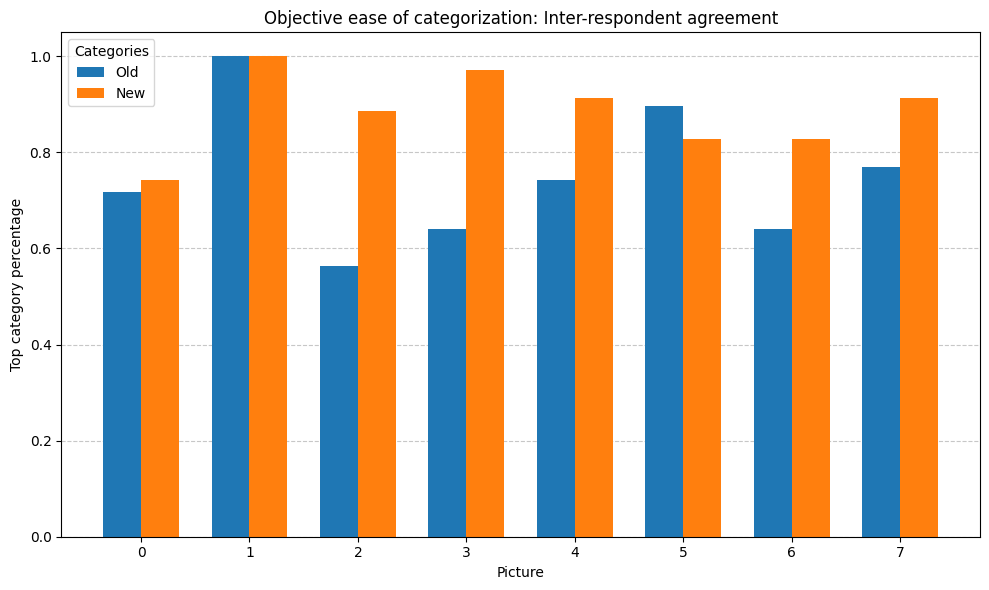

In [49]:
# Setup
x = np.arange(len(agreement_df))  # the label locations
width = 0.35            # the width of the bars

fig, ax = plt.subplots(figsize=(10,6))

bars1 = ax.bar(x - width/2, agreement_df['old'], width, label='Old')
bars2 = ax.bar(x + width/2, agreement_df['new'], width, label='New')

# Labels etc.
ax.set_ylabel('Top category percentage')
ax.set_xlabel('Picture')
ax.set_title('Objective ease of categorization: Inter-respondent agreement')
ax.set_xticks(x)
#ax.set_xticklabels(df['picture'], rotation=45, ha='right')
ax.grid(True, axis='y', linestyle='--', alpha=0.7)
ax.set_axisbelow(True)
ax.legend(title='Categories', labels=['Old', 'New'])


plt.tight_layout()
plt.show()

In [ ]:
ax = perc.plot(kind='bar', figsize=(10,6), width=0.8)
plt.title('Categorization confidence: Old vs. new categories')
plt.ylabel('Percentage of responses')
plt.xlabel('Categorization confidence')
ax.set_xticklabels([5,4,3,2,1], rotation=0)
ax.grid(True, axis='y', linestyle='--', alpha=0.7)
ax.set_axisbelow(True)
ax.legend(title='Categories', labels=['Old', 'New'])
plt.tight_layout()
plt.show()

# Brief look at open text column

In [53]:
pd.set_option('display.max_rows', None)
display(df[df['block']==0]['K03'])

4     Unterschied zwischen Abfall und Wilder Müllkip...
5                                                   NaN
6                                                   NaN
7                                                   NaN
8                                                   NaN
9                                                   NaN
10    Wilde Müllkippe und Abfall finde ich schwierig...
11                                                  NaN
13    Abfall und wilde Müllkippe bin ich mir im Unte...
18    Abfall vs wilde Müllkippe, was gehört wozu?\nW...
19                                                  NaN
22                                                  NaN
23                                                  NaN
24                                                  NaN
29                                                  NaN
31                                                  NaN
32    Das Bild mit den Steinlatten an der Säule war ...
33    Unterscheidung zwischen Abfall und wilde M

In [54]:
df[df['block']==0]['K03'].dropna().to_csv('old_cat_open_text.txt', index=False, header=False)

In [96]:
display(df[df['block']==1]['K03'])

0       Müll am Straßenrand etwas anderes als Sperrmüll
1                                                   NaN
2                                                   NaN
3     Manchmal undeutlich ob das jetzt Sperrmüll ist...
12    Mehrdeutigkeit, Interpretationsspielraum ob Ko...
14                                                  NaN
15                          Mehrere passende Kategorien
16                                                  NaN
17    Die unterschiedliche müllensorgungsarten zu ka...
20                                                  NaN
21                                                  NaN
25                                                  NaN
26                                                  NaN
27                                                  NaN
28    Manchmal gab es bei den Unterkategorien zur Mü...
30                                                  NaN
36                                                  NaN
40    Ich fand es bei den ganzen Müll Bildern sc

In [55]:
df[df['block']==1]['K03'].dropna().to_csv('new_cat_open_text.txt', index=False, header=False)